In [1]:


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SpeechRecognition
!pip install google-cloud-speech pandas
!pip install pydub
!apt install ffmpeg
!pip install FER

In [3]:
import os
import speech_recognition as sr
import spacy
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from google.cloud import speech
import pandas as pd
import os
import glob
from pydub import AudioSegment

# Text Models

In [71]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, SequentialSampler, TensorDataset
import numpy as np
import speech_recognition as sr
from sklearn.preprocessing import LabelEncoder

# Function to transcribe audio to text using Google Speech Recognition
def transcribe_audio(audio_path, language="ur-PK"):
    recognizer = sr.Recognizer()
    audio_file = sr.AudioFile(audio_path)
    with audio_file as source:
        audio_data = recognizer.record(source)
    try:
        transcript = recognizer.recognize_google(audio_data, language=language)
        return transcript
    except sr.UnknownValueError:
        return "Google Speech Recognition could not understand the audio"
    except sr.RequestError as e:
        return f"Could not request results from Google Speech Recognition service; {e}"

# Path to the new audio file
new_audio_path = '/content/drive/MyDrive/Use_Case/audios/1.wav'

# Transcribe the audio file
transcribed_text = transcribe_audio(new_audio_path)

# Print the transcribed text
print("Transcribed Text:", transcribed_text)

# Load the saved BERT model and tokenizer
model_path = '/content/drive/MyDrive/work2/Final/Text_Work/BERTModel'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Tokenize the transcribed text
encoded_dict = tokenizer.encode_plus(
    transcribed_text,
    add_special_tokens=True,
    max_length=64,
    truncation=True,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_dict['input_ids']
attention_masks = encoded_dict['attention_mask']

# Create DataLoader for the transcribed text
dataset = TensorDataset(input_ids, attention_masks)
dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)

# Prediction function
def predict(model, dataloader):
    model.eval()
    predictions = []

    for batch in dataloader:
        batch = tuple(t.to('cpu') for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)

    return predictions

# Get predictions for the transcribed text
predictions = predict(model, dataloader)

# Get the predicted sentiment label
predicted_label = np.argmax(predictions, axis=2).flatten()

# Map the label back to the sentiment
label_encoder = LabelEncoder()
label_encoder.fit(['neutral', 'positive', 'negative'])  # Use the same labels used during training
predicted_sentiment = label_encoder.inverse_transform(predicted_label)

print(f"Predicted Sentiment: {predicted_sentiment[0]}")
# Save the prediction into a CSV file with the required columns
output_data = {
    'file': [os.path.basename(new_audio_path)],
    'modality': ['T'],
    'senti': [predicted_sentiment[0]],

    'Model1': [predicted_sentiment[0]],
    'Model2': [''],
    'Model3': ['']
}

output_df = pd.DataFrame(output_data)

# Define the output CSV file path
output_csv_path = '/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv'
output_df.to_csv(output_csv_path, index=False)

print(f"Prediction saved to {output_csv_path}")

Transcribed Text: پلیز ایک مشہور برینڈ ہے اور لوگوں کو بہت پسند ہے ان کے فلیور کی ٹیکسچر کافی مشہور ہے مشہور ہیں لیکن میرے حساب سے کچھ اور ازمانے کی ضرورت ہے پلیز مجھے بہت پسند ہے اور مجھے لیز اچھے لگتے ہیں
Predicted Sentiment: negative
Prediction saved to /content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv


In [72]:

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head()


,file,modality,senti,Model1,Model2,Model3
0,1.wav,T,negative,negative,NaN,NaN


## Text Model 2

## Text Model 3

#Video Models

In [8]:
import moviepy.editor as mp
import speech_recognition as sr
from pydub import AudioSegment
import os
import pandas as pd

def video_to_audio(video_path, audio_path):
    """Convert video file to audio file."""
    video = mp.VideoFileClip(video_path)
    video.audio.write_audiofile(audio_path)

def get_audio_length(file_path):
    """Return the length of the audio file in seconds."""
    audio = AudioSegment.from_file(file_path)
    return len(audio) / 1000.0  # Convert milliseconds to seconds

def transcribe_audio_speech_recognition(audio_file_path):
    """Transcribe the given local audio file using the speech_recognition library."""
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)
        try:
            transcript = recognizer.recognize_google(audio_data, language="ur-PK")
            return transcript
        except sr.UnknownValueError:
            print("Google Speech Recognition could not understand the audio")
            return None
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None

def read_words_from_file(file_path):
    """Read words from a file and return them as a list."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return [line.strip().lower() for line in file.readlines()]
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

# Convert video to audio
video_file_path = '/content/drive/MyDrive/Use_Case/videos/1.mp4'
audio_file_path = '/content/drive/MyDrive/Use_Case/audios/1.wav'
video_to_audio(video_file_path, audio_file_path)

# Get audio length
length_in_seconds = get_audio_length(audio_file_path)
print(f"The length of the audio file is {length_in_seconds} seconds.")

# Transcribe audio
transcript = transcribe_audio_speech_recognition(audio_file_path)
if transcript:
    print("Transcript:", transcript)
    words_in_transcript = transcript.split()
    transcript_length = len(words_in_transcript)
    print(f"Transcript Length (in words): {transcript_length}")

    # Read positive and negative words from files
    negative_words = read_words_from_file('/content/drive/MyDrive/Use_Case/dictionary/urdu_negative_words.txt')
    positive_words = read_words_from_file('/content/drive/MyDrive/Use_Case/dictionary/urdu_positive_words.txt')

    results = []
    negative_count, positive_count = 0, 0
    for index, word in enumerate(words_in_transcript):
        position = (index + 1) / transcript_length * length_in_seconds
        if word.lower() in negative_words:
            negative_count += 1
            results.append({'Word': word, 'Type': 'Negative', 'Position': index + 1, 'Time': round(position)})
        elif word.lower() in positive_words:
            positive_count += 1
            results.append({'Word': word, 'Type': 'Positive', 'Position': index + 1, 'Time': round(position)})

    # Create DataFrame and display results
    df = pd.DataFrame(results)
    print(df)
    print(f"Total Negative Words: {negative_count}")
    print(f"Total Positive Words: {positive_count}")
else:
    print("No transcript available.")



chunk:   7%|▋         | 32/464 [00:22<05:00,  1.44it/s, now=None]

MoviePy - Writing audio in /content/drive/MyDrive/Use_Case/audios/1.wav




chunk:   0%|          | 0/464 [00:00<?, ?it/s, now=None]

chunk:   8%|▊         | 36/464 [00:00<00:02, 185.14it/s, now=None]

chunk:  36%|███▌      | 167/464 [00:00<00:00, 661.27it/s, now=None]

chunk:  63%|██████▎   | 292/464 [00:00<00:00, 882.11it/s, now=None]

chunk:  88%|████████▊ | 408/464 [00:00<00:00, 969.88it/s, now=None]


chunk:   7%|▋         | 32/464 [00:22<05:08,  1.40it/s, now=None]

MoviePy - Done.
The length of the audio file is 21.04 seconds.
Transcript: پلیز ایک مشہور برینڈ ہے اور لوگوں کو بہت پسند ہے ان کے فلیور کی ٹیکسچر کافی مشہور ہے مشہور ہیں لیکن میرے حساب سے کچھ اور ازمانے کی ضرورت ہے پلیز مجھے بہت پسند ہے اور مجھے لیز اچھے لگتے ہیں
Transcript Length (in words): 42
    Word      Type  Position  Time
0  مشہور  Positive         3     2
1   پسند  Positive        10     5
2   کافی  Positive        17     9
3  مشہور  Positive        18     9
4  مشہور  Positive        20    10
5   لیکن  Negative        22    11
6   پسند  Positive        35    18
7   اچھے  Positive        40    20
Total Negative Words: 1
Total Positive Words: 7


In [9]:
import speech_recognition as sr
from pydub import AudioSegment
import os
import pandas as pd

def get_audio_length(file_path):
    """Return the length of the audio file in seconds."""
    audio = AudioSegment.from_file(file_path)
    return len(audio) / 1000.0  # Convert milliseconds to seconds

def transcribe_audio_speech_recognition(audio_file_path):
    """Transcribe the given local audio file using the speech_recognition library."""
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file_path) as source:
        audio_data = recognizer.record(source)
        try:
            transcript = recognizer.recognize_google(audio_data, language="ur-PK")
            return transcript
        except sr.UnknownValueError:
            print("Google Speech Recognition could not understand the audio")
            return None
        except sr.RequestError as e:
            print(f"Could not request results from Google Speech Recognition service; {e}")
            return None

def read_words_from_file(file_path):
    """Read words from a file and return them as a list."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return [line.strip().lower() for line in file.readlines()]
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

audio_file_path = '/content/drive/MyDrive/Use_Case/audios/1.wav'
length_in_seconds = get_audio_length(audio_file_path)
print(f"The length of the audio file is {length_in_seconds} seconds.")

transcript = transcribe_audio_speech_recognition(audio_file_path)
if transcript:
    print("Transcript:", transcript)
    words_in_transcript = transcript.split()
    transcript_length = len(words_in_transcript)
    print(f"Transcript Length (in words): {transcript_length}")

    negative_words = read_words_from_file('/content/drive/MyDrive/Use_Case/dictionary/urdu_negative_words.txt')
    positive_words = read_words_from_file('/content/drive/MyDrive/Use_Case/dictionary/urdu_positive_words.txt')

    results37 = []
    negative_count, positive_count = 0, 0
    negative_positions, positive_positions = [], []  # Lists to store positions

    for index, word in enumerate(words_in_transcript):
        position = (index+1) / transcript_length * length_in_seconds
        if word.lower() in negative_words:
            negative_count += 1
            negative_positions.append(round(position))  # Append to negative_positions list
            # results.append({'Word': word, 'Type': 'Negative', 'Position': index+1, 'Time': round(position)})
        elif word.lower() in positive_words:
            positive_count += 1
            positive_positions.append(round(position))  # Append to positive_positions list
            # results.append({'Word': word, 'Type': 'Positive', 'Position': index+1, 'Time': round(position)})

    print(f"Total Negative Words: {negative_count}")
    print(f"Total Positive Words: {positive_count}")
    print("Negative Word Positions:", negative_positions)
    print("Positive Word Positions:", positive_positions)

    results37.append({'Length': length_in_seconds, 'audio_name': os.path.basename(audio_file_path),'Transcript' : transcript , 'negative_count': negative_count, 'positive_count': positive_count, 'negative_positions' : negative_positions, 'positive_positions': positive_positions})
    # Create DataFrame
    df = pd.DataFrame(results37)

    # Save results to a CSV file
    csv_file_path = '/content/drive/MyDrive/Use_Case/transcription/1.csv'
    df.to_csv(csv_file_path, index=False)
    print(f"Results saved to {csv_file_path}")



else:
    print("No transcript available.")


The length of the audio file is 21.04 seconds.
Transcript: پلیز ایک مشہور برینڈ ہے اور لوگوں کو بہت پسند ہے ان کے فلیور کی ٹیکسچر کافی مشہور ہے مشہور ہیں لیکن میرے حساب سے کچھ اور ازمانے کی ضرورت ہے پلیز مجھے بہت پسند ہے اور مجھے لیز اچھے لگتے ہیں
Transcript Length (in words): 42
Total Negative Words: 1
Total Positive Words: 7
Negative Word Positions: [11]
Positive Word Positions: [2, 5, 9, 9, 10, 18, 20]
Results saved to /content/drive/MyDrive/Use_Case/transcription/1.csv


In [10]:
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/1.csv')
df.head()

,Length,audio_name,Transcript,negative_count,positive_count,negative_positions,positive_positions
0,21.04,1.wav,پلیز ایک مشہور برینڈ ہے اور لوگوں کو بہت پسند ...,1,7,[11],"[2, 5, 9, 9, 10, 18, 20]"


In [29]:
import cv2
import pandas as pd
import os

# Video file path
video_file_path = '/content/drive/MyDrive/Use_Case/videos/1.mp4'
video_name = os.path.basename(video_file_path).split('.')[0]  # Extract name without extension

# Create a folder to store frames if it doesn't exist
output_folder = '/content/drive/MyDrive/Use_Case/Frames/1'
os.makedirs(output_folder, exist_ok=True)

# Load positions from the CSV file
csv_file_path = '/content/drive/MyDrive/Use_Case/transcription/1.csv'
df = pd.read_csv(csv_file_path)

# Convert positions to lists of integers
df['negative_positions'] = df['negative_positions'].apply(lambda x: eval(x))
df['positive_positions'] = df['positive_positions'].apply(lambda x: eval(x))

# Concatenate, flatten, and remove duplicates from positions
all_positions = df['negative_positions'] + df['positive_positions']
times_in_seconds = list(set([int(time) for sublist in all_positions for time in sublist]))

# Initialize video capture
cap = cv2.VideoCapture(video_file_path)

frame_info = []  # List to store frame information
fps = cap.get(cv2.CAP_PROP_FPS)

# Extract frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    current_time = int(cap.get(cv2.CAP_PROP_POS_MSEC) // 1000)  # Current time in seconds

    if current_time in times_in_seconds:
        frame_filename = os.path.join(output_folder, f'{video_name}_frame_{current_time}.jpg')
        cv2.imwrite(frame_filename, frame)
        frame_info.append({'Video Name': video_name, 'Frame Path': frame_filename, 'Time in Seconds': current_time})
        times_in_seconds.remove(current_time)  # Remove extracted time

# Release video capture object
cap.release()

# Save frame information to a new CSV file
frame_info_df = pd.DataFrame(frame_info)
frames_csv_path = '/content/drive/MyDrive/Use_Case/frames_path/1.csv'
frame_info_df.to_csv(frames_csv_path, index=False)

print("Frames extracted and saved in", output_folder)
print(f"Frame information saved to {frames_csv_path}")


Frames extracted and saved in /content/drive/MyDrive/Use_Case/Frames/1
Frame information saved to /content/drive/MyDrive/Use_Case/frames_path/1.csv


test

In [37]:
import cv2
import pandas as pd
import os

# Video file path
video_file_path = '/content/drive/MyDrive/Use_Case/videos/1.mp4'
video_name = os.path.basename(video_file_path).split('.')[0]  # Extract name without extension

# Create a folder to store frames if it doesn't exist
output_folder = f'/content/drive/MyDrive/Use_Case/Frames/{video_name}'
os.makedirs(output_folder, exist_ok=True)

# Load positions from the CSV file
csv_file_path = '/content/drive/MyDrive/Use_Case/transcription/1.csv'
df = pd.read_csv(csv_file_path)

# Convert positions to lists of integers
negative_positions = eval(df['negative_positions'][0])
positive_positions = eval(df['positive_positions'][0])

# Initialize video capture
cap = cv2.VideoCapture(video_file_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

frame_info = []  # List to store frame information

# Extract frames
for sec in range(int(duration) + 1):
    cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)
    ret, frame = cap.read()
    if not ret:
        break

    frame_filename = os.path.join(output_folder, f'{video_name}_frame_{sec}.jpg')
    cv2.imwrite(frame_filename, frame)

    # Determine if the frame is negative or positive
    is_in_Dictionary = 'Y' if sec in negative_positions else 'N'
    is_in_Dictionary = 'Y' if sec in positive_positions else 'N'

    frame_info.append({
        'Video Name': video_name,
        'Frame Path': frame_filename,
        'Time in Seconds': sec,
        'Key_Frame': is_in_Dictionary
    })

# Release video capture object
cap.release()

# Save frame information to a new CSV file
frame_info_df = pd.DataFrame(frame_info)
frames_csv_path = f'/content/drive/MyDrive/Use_Case/frames_path/{video_name}_frames_info.csv'
frame_info_df.to_csv(frames_csv_path, index=False)

print("Frames extracted and saved in", output_folder)
print(f"Frame information saved to {frames_csv_path}")


Frames extracted and saved in /content/drive/MyDrive/Use_Case/Frames/1
Frame information saved to /content/drive/MyDrive/Use_Case/frames_path/1_frames_info.csv


In [38]:
df = pd.read_csv('/content/drive/MyDrive/Use_Case/frames_path/1_frames_info.csv')
df.head(22)


,Video Name,Frame Path,Time in Seconds,Key_Frame
0,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,0,N
1,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,1,N
2,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,2,Y
3,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,3,N
4,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,4,N
5,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,5,Y
6,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,6,N
7,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,7,N
8,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,8,N
9,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,9,Y


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Use_Case/frames_path/1.csv')
df.head()

##Video Model 2

In [73]:
import pandas as pd
import numpy as np
import cv2
import joblib
from skimage.feature import hog
import os

# Function to preprocess images
def preprocess_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (48, 48))
    img = cv2.equalizeHist(img)
    return img

# Load the model
model_path = "/content/drive/MyDrive/work2/Final/Image_Models/random_forest_model.pkl"
loaded_rf_model = joblib.load(model_path)

# Load the new frames CSV file
frames_csv_path = '/content/drive/MyDrive/Use_Case/frames_path/1_frames_info.csv'
df_frames = pd.read_csv(frames_csv_path)

# Apply preprocessing to each image and prepare for prediction
images = np.array([preprocess_image(fp) for fp in df_frames['Frame Path']])

# Extract HOG features from the images
hog_features = [hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys') for image in images]

# Predict using the loaded model
y_pred = loaded_rf_model.predict(hog_features)

# Save the predictions in the DataFrame
df_frames['Predicted Sentiment'] = y_pred

# Save the updated DataFrame to a new CSV file
predictions_csv_path = '/content/drive/MyDrive/Use_Case/frames_path/random_forest_on_1.csv'
df_frames.to_csv(predictions_csv_path, index=False)

print("Predictions saved to", predictions_csv_path)

# Load the CSV file
df = pd.read_csv(predictions_csv_path)

# Get the most repeated values in 'Predicted Sentiment'
most_repeated_values = df['Predicted Sentiment'].value_counts()
print(most_repeated_values)

# Determine the overall sentiment
if most_repeated_values.idxmax() == 0:
    Senti = "Neutral"
elif most_repeated_values.idxmax() == 1:
    Senti = "Positive"
elif most_repeated_values.idxmax() == 2:
    Senti = "Negative"

# Prepare the output data
output_data = {
    'file': [os.path.basename(new_audio_path)],
    'modality': ['V'],
    'senti': [Senti],
    'Model1': [''],
    'Model2': [Senti],
    'Model3': ['']
}

output_df = pd.DataFrame(output_data)

# Define the output CSV file path
output_csv_path = '/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv'

# Append to the existing CSV file
output_df.to_csv(output_csv_path, mode='a', header=False, index=False)

print(f"Prediction saved to {output_csv_path}")


Predictions saved to /content/drive/MyDrive/Use_Case/frames_path/random_forest_on_1.csv
Predicted Sentiment
0    21
Name: count, dtype: int64
Prediction saved to /content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv


In [74]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head(10)

,file,modality,senti,Model1,Model2,Model3
0,1.wav,T,negative,negative,NaN,NaN
1,1.wav,V,Neutral,NaN,Neutral,NaN


In [60]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/frames_path/random_forest_on_1.csv')
df.head(10)

,Video Name,Frame Path,Time in Seconds,Key_Frame,Predicted Sentiment
0,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,0,N,0
1,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,1,N,0
2,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,2,Y,0
3,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,3,N,0
4,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,4,N,0
5,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,5,Y,0
6,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,6,N,0
7,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,7,N,0
8,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,8,N,0
9,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,9,Y,0


In [20]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/frames_path/random_forest_on_1.csv')
df.head(10)


,Video Name,Frame Path,Time in Seconds,Predicted Sentiment
0,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,2,0
1,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,5,0
2,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,9,0
3,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,10,0
4,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,11,0
5,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,18,0
6,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,20,1


##Video Model 1

1/1 [==============================] - 3s 3s/step
Predictions saved to /content/drive/MyDrive/Use_Case/frames_path/predictions_1_mobilenet.csv
Updated 'Model1' column for file 1.wav with sentiment Neutral.


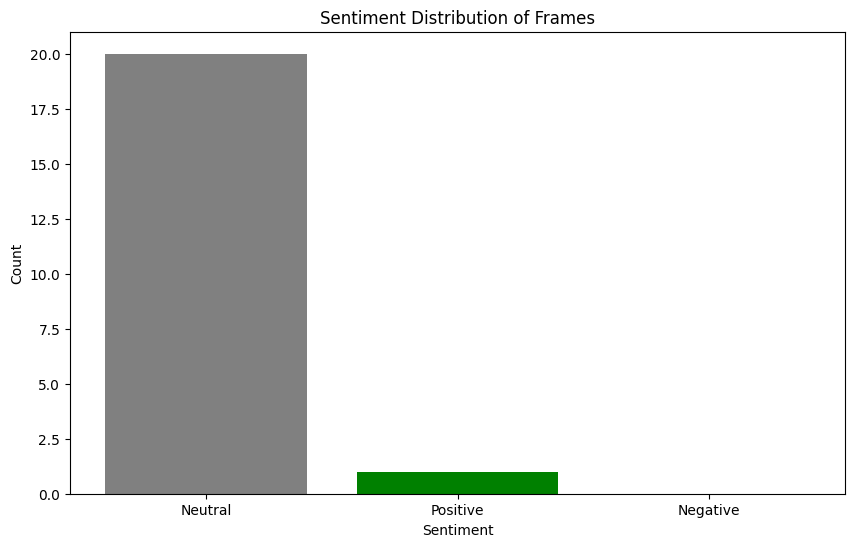

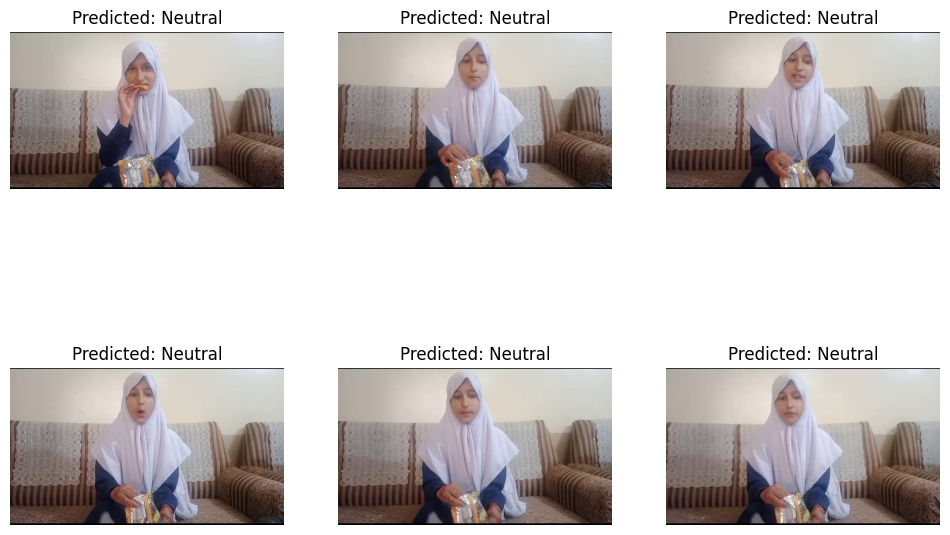

In [77]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import matplotlib.pyplot as plt

# Function to preprocess images
def preprocess_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match MobileNetV2 input
    img = preprocess_input(img)  # Preprocess as per MobileNetV2 requirements
    return img

# Load the saved model
model_path = '/content/drive/MyDrive/work2/Final/Image_Models/sentiment_model.h5'
loaded_model = tf.keras.models.load_model(model_path)

# Load the new frames CSV file
frames_csv_path = '/content/drive/MyDrive/Use_Case/frames_path/1_frames_info.csv'
df_frames = pd.read_csv(frames_csv_path)

# Apply preprocessing to each image and prepare for prediction
images = np.array([preprocess_image(fp) for fp in df_frames['Frame Path']])

# Make predictions using the loaded model
predictions = loaded_model.predict(images)

# Convert one-hot encoded predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Add predictions to the DataFrame
df_frames['Predicted Sentiment'] = predicted_labels

# Save the updated DataFrame to a new CSV file
predictions_csv_path = '/content/drive/MyDrive/Use_Case/frames_path/predictions_1_mobilenet.csv'
df_frames.to_csv(predictions_csv_path, index=False)

print("Predictions saved to", predictions_csv_path)

# Determine the overall sentiment for the MobileNetV2 model
most_repeated_values = df_frames['Predicted Sentiment'].value_counts().reindex([0, 1, 2], fill_value=0)
if most_repeated_values.idxmax() == 0:
    Senti = "Neutral"
elif most_repeated_values.idxmax() == 1:
    Senti = "Positive"
elif most_repeated_values.idxmax() == 2:
    Senti = "Negative"

# Load the main CSV file
main_csv_path = '/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv'
df_main = pd.read_csv(main_csv_path)

# Find the corresponding row based on 'file' and 'modality'
filename = os.path.basename(new_audio_path)
row_index = df_main[(df_main['file'] == filename) & (df_main['modality'] == 'V')].index

# Update 'Model2' column value
if not row_index.empty:
    df_main.at[row_index[0], 'Model1'] = Senti
    # Save the updated DataFrame back to the CSV file
    df_main.to_csv(main_csv_path, index=False)
    print(f"Updated 'Model1' column for file {filename} with sentiment {Senti}.")
else:
    print(f"No matching row found for file {filename} with modality 'V'.")

# Optional: Visualization of predictions (if needed)
plt.figure(figsize=(10, 6))
plt.bar(['Neutral', 'Positive', 'Negative'], most_repeated_values, color=['gray', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution of Frames')
plt.show()

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = cv2.imread(df_frames['Frame Path'].iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Predicted: {['Neutral', 'Positive', 'Negative'][predicted_labels[i]]}")
    plt.axis('off')
plt.show()


In [78]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head(10)

,file,modality,senti,Model1,Model2,Model3
0,1.wav,T,negative,negative,NaN,NaN
1,1.wav,V,Neutral,Neutral,Neutral,NaN


In [19]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/frames_path/predictions_1_mobilenet.csv')
df.head(10)


,Video Name,Frame Path,Time in Seconds,Predicted Sentiment
0,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,2,0
1,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,5,0
2,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,9,0
3,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,10,0
4,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,11,0
5,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,18,0
6,1,/content/drive/MyDrive/Use_Case/Frames/1/1_fra...,20,0


#Audio Models Testing

##Audio First Model

In [81]:
import librosa
import numpy as np
import tensorflow as tf
import joblib
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os

# Function to extract features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.mean(np.concatenate((mfccs, chroma, mel, contrast), axis=0), axis=1)
    return features

# Path to the saved model and scaler
model_path = '/content/drive/MyDrive/work2/Final/best_audio_model/best_model.h5'
scaler_path = '/content/drive/MyDrive/work2/Final/best_audio_model/scaler.pkl'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)

# Load the saved scaler
scaler = joblib.load(scaler_path)

# Path to the new audio file
new_audio_path = '/content/drive/MyDrive/Use_Case/audios/1.wav'

# Extract features from the new audio file
new_features = extract_features(new_audio_path)

# Standardize the features using the saved scaler
new_features = scaler.transform([new_features])

# Reshape for LSTM input
new_features = np.expand_dims(new_features, -1)

# Make predictions using the loaded model
prediction = loaded_model.predict(new_features)

# Decode the prediction
predicted_label = np.argmax(prediction, axis=1)

# Map the label back to the sentiment
label_encoder = LabelEncoder()
label_encoder.fit(['Neutral', 'Positive', 'Negative'])  # Use the same labels used during training
predicted_sentiment = label_encoder.inverse_transform(predicted_label)

print(f"Predicted Sentiment: {predicted_sentiment[0]}")

# Save the prediction into a CSV file with the required columns
output_data = {
    'file': [os.path.basename(new_audio_path)],
    'modality': ['A'],
    'senti': [predicted_sentiment[0]],
    'Model1': [predicted_sentiment[0]],
    'Model2': [''],
    'Model3': ['']
}

output_df = pd.DataFrame(output_data)

# Define the output CSV file path
output_csv_path = '/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv'

# Append to the existing main CSV file
if os.path.exists(output_csv_path):
    output_df.to_csv(output_csv_path, mode='a', header=False, index=False)
else:
    output_df.to_csv(output_csv_path, index=False)

print(f"Prediction saved to {output_csv_path}")


1/1 [==============================] - 1s 886ms/step
Predicted Sentiment: Neutral
Prediction saved to /content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv


In [86]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head(10)

,file,modality,senti,Model1,Model2,Model3
0,1.wav,T,negative,negative,NaN,NaN
1,1.wav,V,Neutral,Neutral,Neutral,NaN
2,1.wav,A,Neutral,Neutral,NaN,NaN


## Audio Model 2

In [87]:
import librosa
import numpy as np
import tensorflow as tf
import joblib
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

# Function to extract features from audio files
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.mean(np.concatenate((mfccs, chroma, mel, contrast), axis=0), axis=1)
    return features

# Path to the saved model and scaler
model_path = '/content/drive/MyDrive/work2/Final/audio_models/Audio_sentiment.h5'
scaler_path = '/content/drive/MyDrive/work2/Final/audio_models/scaler.pkl'

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)

# Load the saved scaler
scaler = joblib.load(scaler_path)

# Path to the new audio file
new_audio_path = '/content/drive/MyDrive/Use_Case/audios/1.wav'

# Extract features from the new audio file
new_features = extract_features(new_audio_path)

# Standardize the features using the saved scaler
new_features = scaler.transform([new_features])

# Reshape for LSTM input
new_features = np.expand_dims(new_features, -1)

# Make predictions using the loaded model
prediction = loaded_model.predict(new_features)

# Decode the prediction
predicted_label = np.argmax(prediction, axis=1)

# Map the label back to the sentiment
label_encoder = LabelEncoder()
label_encoder.fit(['Neutral', 'Positive', 'Negative'])  # Use the same labels used during training
predicted_sentiment = label_encoder.inverse_transform(predicted_label)

print(f"Predicted Sentiment: {predicted_sentiment[0]}")

# Define the output CSV file path
output_csv_path = '/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv'

# Load the main CSV file
df_main = pd.read_csv(output_csv_path)

# Find the corresponding row based on 'file' and 'modality'
filename = os.path.basename(new_audio_path)
row_index = df_main[(df_main['file'] == filename) & (df_main['modality'] == 'A')].index

# Update 'Model2' column value
if not row_index.empty:
    df_main.at[row_index[0], 'Model2'] = predicted_sentiment[0]
else:
    # If the row doesn't exist, add a new row with modality 'A' and the new sentiment
    new_row = {
        'file': filename,
        'modality': 'A',
        'senti': '',  # This can be filled with appropriate value if needed
        'Model1': '',  # Assuming this will be filled later
        'Model2': predicted_sentiment[0],
        'Model3': ''  # Assuming this will be filled later
    }
    df_main = df_main.append(new_row, ignore_index=True)

# Save the updated DataFrame back to the CSV file
df_main.to_csv(output_csv_path, index=False)

print(f"Updated 'Model2' column for file {filename} with sentiment {predicted_sentiment[0]}.")
print(f"Prediction saved to {output_csv_path}")


1/1 [==============================] - 1s 838ms/step
Predicted Sentiment: Positive
Updated 'Model2' column for file 1.wav with sentiment Positive.
Prediction saved to /content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv


In [88]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head(10)

,file,modality,senti,Model1,Model2,Model3
0,1.wav,T,negative,negative,NaN,NaN
1,1.wav,V,Neutral,Neutral,Neutral,NaN
2,1.wav,A,Neutral,Neutral,Positive,NaN


#Text Models

In [45]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Use_Case/transcription/sentiment_predictions_UseCases.csv')
df.head(10)




,file,modality,senti,Model1,Model2,Model3
0,1.wav,A,negative,negative,NaN,NaN


In [40]:
# prompt: save into csv

df_frames.to_csv('/content/drive/MyDrive/Use_Case/frames_path/predictions_1_mobilenet.csv', index=False)


#Dumy

In [ ]:
import cv2
import pandas as pd
import os

def extract_frames(video_path, frames_directory, video_name):
    if not os.path.exists(frames_directory):
        os.makedirs(frames_directory)

    cap = cv2.VideoCapture(video_path)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_details = []

    for frame_no in range(0, total_frames, int(frame_rate)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        if ret:
            second = int(frame_no / frame_rate)
            frame_file_name = f"{os.path.splitext(video_name)[0]}@second_{second}.jpg"
            frame_file_path = os.path.join(frames_directory, frame_file_name)
            cv2.imwrite(frame_file_path, frame)
            frame_details.append({'video_name': video_name, 'time_period': second, 'frame_path': frame_file_path})
        else:
            break

    cap.release()
    return frame_details

frame_details_df = pd.DataFrame(columns=['video_name', 'time_period', 'frame_path'])

# Directory containing videos
videos_directory = '/content/drive/MyDrive/Use_Case/videos'
video_files = [f for f in os.listdir(videos_directory) if f.endswith('.mp4')]

# Process each video file
for video_file in video_files:
    video_path = os.path.join(videos_directory, video_file)
    frames_directory = os.path.join('/content/drive/MyDrive/Use_Case/', os.path.splitext(video_file)[0])

    frame_details = extract_frames(video_path, frames_directory, video_file)
    frame_details_df = pd.concat([frame_details_df, pd.DataFrame(frame_details)], ignore_index=True)

# Save the frame details
frame_details_df.to_csv('/content/drive/MyDrive/Use_Case/frame_details.csv', index=False)
print("Frame details saved to /content/drive/MyDrive/Use_Case/frame_details.csv")
